In [1]:
#importing necessary libraries - Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#starting a spark session - Pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession \
    .builder \
    .appName("BigData-Project") \
    .getOrCreate()
sc = SparkContext.getOrCreate()
     


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
flights_2008 = spark.read.csv("2008.csv.bz2", header=True, inferSchema=True)

In [ ]:
# flights_2008.show(10)

In [5]:
airports = spark.read.csv("airports.csv", header=True, inferSchema=True)
carriers = spark.read.csv("carriers.csv", header=True, inferSchema=True)
plane_data = spark.read.csv("plane-data.csv", header=True, inferSchema=True)


In [6]:
airports.select('country').distinct().collect()

[Row(country='Palau'),
 Row(country='N Mariana Islands'),
 Row(country='Thailand'),
 Row(country='USA'),
 Row(country='Federated States of Micronesia')]

In [7]:
#filtering the dataset with only USA airport records
airport_usa = airports.filter("country == 'USA'")
# airport_usa.show(10)

In [8]:
iata_usa = airport_usa.select('iata').rdd.flatMap(lambda x: x).distinct().collect()

In [9]:
#Arrival/Departure Country = USA
flights_usa = flights_2008.filter((flights_2008.Origin.isin(iata_usa)) | (flights_2008.Dest.isin(iata_usa)))
     

In [10]:
flights_usa.groupBy('UniqueCarrier').count().show()

+-------------+------+
|UniqueCarrier| count|
+-------------+------+
|           UA|154036|
|           AA|204519|
|           NW|122799|
|           EV| 92383|
|           B6| 67478|
|           DL|151409|
|           OO|195184|
|           F9| 30680|
|           YV| 85686|
|           US|153539|
|           AQ|  7800|
|           MQ|167860|
|           OH| 71934|
|           HA| 18385|
|           XE|138757|
|           AS| 49885|
|           FL| 86856|
|           CO|102702|
|           WN|398966|
|           9E| 88359|
+-------------+------+



In [11]:
#selecting only top 2 carriers = UA and AA
flights_usa = flights_usa.filter(flights_usa.UniqueCarrier.isin('AA','UA'))

In [ ]:
flights_usa.printSchema()

In [12]:
#dropping unnecessary columns
drop_cols = ['FlightNum', 'TailNum', 'AirTime', 'TaxiIn', 'TaxiOut', 'CancellationCode', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']

flights_usa = flights_usa.drop(*drop_cols)

In [13]:
flights_usa=flights_usa.filter((flights_usa.ArrDelay != 'NA')&(flights_usa.DepDelay != 'NA')&(flights_usa.CarrierDelay != 'NA')&(flights_usa.WeatherDelay != 'NA')&(flights_usa.NASDelay != 'NA')&(flights_usa.SecurityDelay != 'NA')&(flights_usa.LateAircraftDelay != 'NA')&(flights_usa.CRSElapsedTime != 'NA')&(flights_usa.ActualElapsedTime != 'NA'))


In [14]:
#correcting schema of required columns
flights_usa = flights_usa.withColumn('ArrDelay', flights_usa.ArrDelay.cast('int'))
flights_usa = flights_usa.withColumn('DepDelay', flights_usa.DepDelay.cast('int'))
flights_usa = flights_usa.withColumn('CarrierDelay', flights_usa.CarrierDelay.cast('int'))
flights_usa = flights_usa.withColumn('WeatherDelay', flights_usa.WeatherDelay.cast('int'))
flights_usa = flights_usa.withColumn('NASDelay', flights_usa.NASDelay.cast('int'))
flights_usa = flights_usa.withColumn('SecurityDelay', flights_usa.SecurityDelay.cast('int'))
flights_usa = flights_usa.withColumn('LateAircraftDelay', flights_usa.LateAircraftDelay.cast('int'))
flights_usa = flights_usa.withColumn('CRSElapsedTime', flights_usa.CRSElapsedTime.cast('int'))
flights_usa = flights_usa.withColumn('ActualElapsedTime', flights_usa.ActualElapsedTime.cast('int'))
flights_usa = flights_usa.withColumn('Cancelled', flights_usa.Cancelled.cast('string'))
flights_usa = flights_usa.withColumn('Diverted', flights_usa.Diverted.cast('string'))

In [15]:
#checking the final schema of the dataframe
flights_usa.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay: integer (nullable = true)
 |-- WeatherDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)



In [16]:
#checking for missing values in every column
from pyspark.sql.functions import isnan, isnull, when, count, col

flights_usa.select([count(when(isnull(c), c)).alias(c) for c in flights_usa.columns]).show()

+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|UniqueCarrier|ActualElapsedTime|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|Cancelled|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+-------------+-----------------+
|   0|    0|         0|        0|            0|                0|             0|       0|       0|     0|   0|       0|        0|       0|           0|           0|       0|            0|                0|
+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+---

In [17]:
#converting pyspark dataframe to pandas dataframe for visualizations
flights_usa_df = flights_usa.toPandas()

In [ ]:
flights_usa_df.head(3)

In [ ]:
# #correlation matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(16,6))
# sns.heatmap(flights_usa_df.corr(), annot=True).set_title('Correlation Matrix Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0, 0.5, 'Departure Delay in minutes')

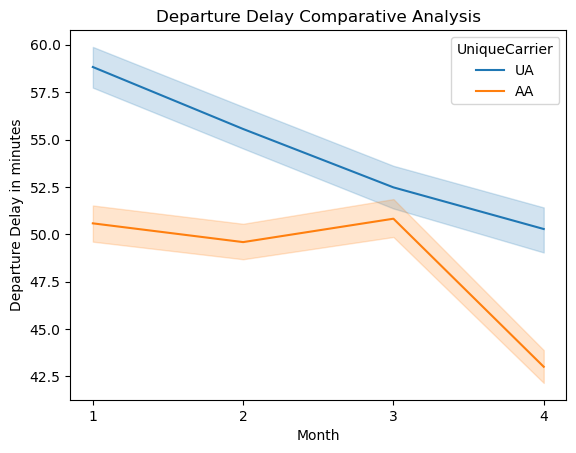

In [18]:
import matplotlib.pyplot as plt
sns.lineplot(x = flights_usa_df["Month"], y = flights_usa_df["DepDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Departure Delay Comparative Analysis")
plt.xticks([1,2,3,4])
plt.xlabel("Month")
plt.ylabel("Departure Delay in minutes")

Text(0, 0.5, 'Arrival Delay in minutes')

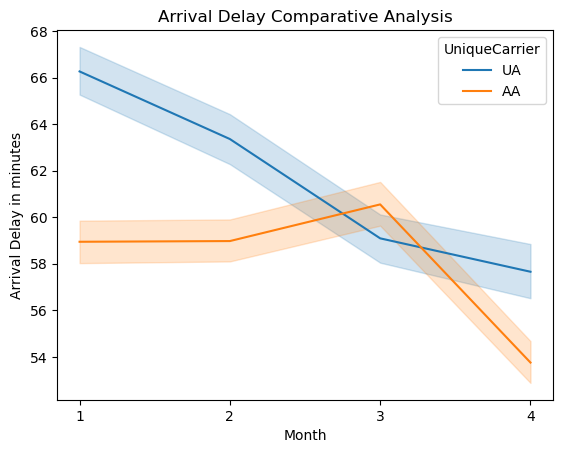

In [19]:
import matplotlib.pyplot as plt
sns.lineplot(x = flights_usa_df["Month"], y = flights_usa_df["ArrDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Arrival Delay Comparative Analysis")
plt.xticks([1,2,3,4])
plt.xlabel("Month")
plt.ylabel("Arrival Delay in minutes")

In [ ]:
import matplotlib.pyplot as plt
sns.scatterplot(x = flights_usa_df["LateAircraftDelay"], y = flights_usa_df["DepDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Departure Delay Comparative Analysis")
plt.ylabel("Departure Delay in minutes")
     

Text(0, 0.5, 'Arrival Delay in minutes')

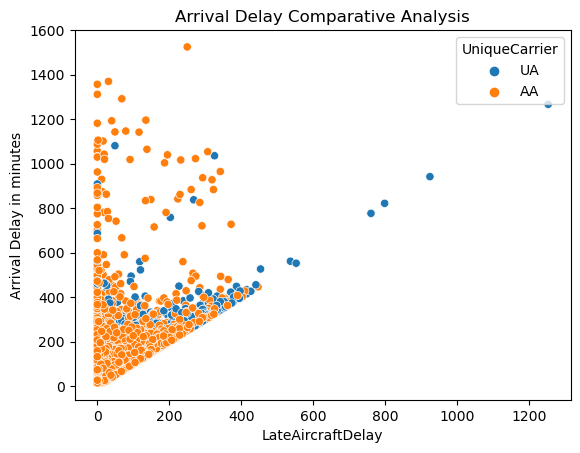

In [20]:
import matplotlib.pyplot as plt
sns.scatterplot(x = flights_usa_df["LateAircraftDelay"], y = flights_usa_df["ArrDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Arrival Delay Comparative Analysis")
plt.ylabel("Arrival Delay in minutes")

In [21]:
enable_grid_search = False

In [22]:
#splitting the 'medical_df' dataframe into train set and test set

flights_usa = flights_usa.withColumn('Cancelled', flights_usa.Cancelled.cast('int'))
flights_usa = flights_usa.withColumn('Diverted', flights_usa.Diverted.cast('int'))

train, test = flights_usa.randomSplit([0.8, 0.2], seed=10)
     

### Linear Regression for Arrival Delay

In [23]:
#Linear Regression Model Pipeline:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

#define stage 1: feature engineering pipeline
#String indexer for UA AA uniqueCarrier

UniqueCarrier = StringIndexer(inputCol = "UniqueCarrier", outputCol = "UniqueCarrier_encoded")

#Create pipeline and pass all stages

fe_pipe = Pipeline(stages = [UniqueCarrier])

#define stage 2: create a vector of all the features required to train the linear regression model 
vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                               outputCol = 'va_features')

#define stage 3: scaling the vectors
std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 

#define stage 4: re-creating a vector of all the scaled features required to train the linear regression model 
vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')

#define stage 5: linear regression model                          
linear_reg = LinearRegression(featuresCol = 'features', labelCol = 'ArrDelay')

#setup the pipeline
lr_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, linear_reg])
     

In [24]:
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

#define stage 1: feature engineering pipeline
#String indexer for UA AA uniqueCarrier

UniqueCarrier = StringIndexer(inputCol = "UniqueCarrier", outputCol = "UniqueCarrier_encoded")

#Create pipeline and pass all stages

fe_pipe = Pipeline(stages = [UniqueCarrier])

#define stage 2: create a vector of all the features required to train the linear regression model 
vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                               outputCol = 'va_features')

#define stage 3: scaling the vectors
std_scalar = StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 

#define stage 4: re-creating a vector of all the scaled features required to train the linear regression model 
vec_assembler_2 = VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')

#define stage 5: linear regression model                          
linear_reg = LinearRegression(featuresCol = 'features', labelCol = 'ArrDelay')

#setup the pipeline
lr_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, linear_reg])


In [25]:
#fitting the linear regression pipe to train data and testing it using test data
lr_model = lr_pipe.fit(train)
lr_flights_arr_df = lr_model.transform(test)

In [26]:
#evaluating the model performance
from pyspark.ml.evaluation import RegressionEvaluator

r2_lr_eval = RegressionEvaluator(labelCol = 'ArrDelay', predictionCol = 'prediction', metricName = 'r2')
r2_lr_eval.evaluate(lr_model.transform(test))

0.9234547419126924

In [27]:
#define stage 5: linear regression model          
vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                               outputCol = 'va_features')

#define stage 3: scaling the vectors
std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 

#define stage 4: re-creating a vector of all the scaled features required to train the linear regression model 
vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')

linear_reg_2 = LinearRegression(featuresCol = 'features', labelCol = 'DepDelay')

#setup the pipeline
lr_pipe_2 = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, linear_reg_2])
     

In [28]:
#fitting the linear regression pipe to train data and testing it using test data
lr_model_2 = lr_pipe_2.fit(train)
lr_flights_dep_df = lr_model_2.transform(test)

In [29]:
#evaluating the model performance
r2_lr_eval_2 = RegressionEvaluator(labelCol = 'DepDelay', predictionCol = 'prediction', metricName = 'r2')
r2_lr_eval_2.evaluate(lr_model_2.transform(test))

0.9284955697615564

In [30]:
coefficient_values_arr = lr_model.stages[-1].coefficients
coefficient_values_dep = lr_model_2.stages[-1].coefficients

In [31]:
coefficient_values_arr = lr_model.stages[-1].coefficients
coefficient_values_dep = lr_model_2.stages[-1].coefficients

In [33]:
important_features_dep = pd.DataFrame({'Features': ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                                'Value': coefficient_values_dep}).sort_values(by=['Value'], ascending=False)
   

In [35]:
important_features_dep

,Features,Value
1,CRSElapsedTime,75.474493
9,LateAircraftDelay,41.807941
6,CarrierDelay,38.482322
7,NASDelay,31.079813
8,SecurityDelay,0.813555
4,Cancelled,0.000000
5,Diverted,0.000000
2,UniqueCarrier_encoded,-0.332729
3,Distance,-0.785822
0,ActualElapsedTime,-78.896397
